In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install tensorflow==2.9.1
import tensorflow as tf

print(tf.__version__)

2.9.1


In [ ]:
import os

print('Training Folder')
for dirpath,filename,dirname in os.walk('/content/drive/MyDrive/Apple leaf disease dataset/train'):
  print(f'There are {len(filename)} directories,{len(dirname)} images in {dirpath}')

print('Testing Folder')
for dirpath,filename,dirname in os.walk('/content/drive/MyDrive/Apple leaf disease dataset/valid'):
  print(f'There are {len(filename)} directories,{len(dirname)} images in {dirpath}')

Training Folder
There are 4 directories,0 images in /content/drive/MyDrive/Apple leaf disease dataset/train
There are 0 directories,2017 images in /content/drive/MyDrive/Apple leaf disease dataset/train/healthy
There are 0 directories,1790 images in /content/drive/MyDrive/Apple leaf disease dataset/train/rust
There are 0 directories,1735 images in /content/drive/MyDrive/Apple leaf disease dataset/train/Black_rot
There are 0 directories,2076 images in /content/drive/MyDrive/Apple leaf disease dataset/train/scab
Testing Folder
There are 4 directories,0 images in /content/drive/MyDrive/Apple leaf disease dataset/valid
There are 0 directories,502 images in /content/drive/MyDrive/Apple leaf disease dataset/valid/healthy
There are 0 directories,440 images in /content/drive/MyDrive/Apple leaf disease dataset/valid/rust
There are 0 directories,490 images in /content/drive/MyDrive/Apple leaf disease dataset/valid/Black_rot
There are 0 directories,504 images in /content/drive/MyDrive/Apple leaf 

In [ ]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

train_dir = '/content/drive/MyDrive/Apple leaf disease dataset/train'
test_dir = '/content/drive/MyDrive/Apple leaf disease dataset/valid'

train_data = image_dataset_from_directory(train_dir,
                                             image_size=(224,224),
                                             label_mode='categorical',
                                             batch_size=32)

test_data = image_dataset_from_directory(test_dir,
                                         image_size=(224,224),
                                         label_mode='categorical',
                                         batch_size=32)

train_data,test_data

Found 7618 files belonging to 4 classes.
Found 1936 files belonging to 4 classes.


(<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>,
 <BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>)

In [ ]:
class_names = train_data.class_names
class_names

['Black_rot', 'healthy', 'rust', 'scab']

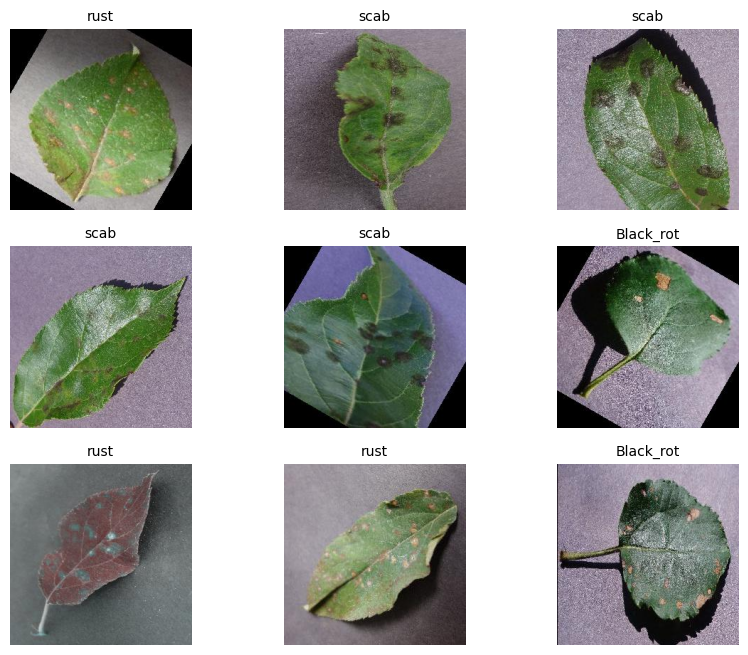

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os

def get_random_image(directory, class_names=class_names):
  # Filter out '.ipynb_checkpoints' from class_names
  valid_class_names = [name for name in class_names if name != '.ipynb_checkpoints']

  # Ensure valid_class_names is not empty before proceeding
  if not valid_class_names:
    print("No valid class names found in the directory.")
    return

  rn = random.randint(0, len(valid_class_names) - 1)
  choice = random.choice(os.listdir(os.path.join(directory, valid_class_names[rn])))
  img_path = os.path.join(directory, valid_class_names[rn], choice)
  img = mpimg.imread(img_path)
  plt.imshow(img)
  fontsize = 10
  plt.title(valid_class_names[rn], fontdict={'fontsize': fontsize})
  plt.axis(False)

plt.figure(figsize=(10, 8))
for i in range(9):
  plt.subplot(3, 3, i + 1)
  get_random_image(train_dir)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

image_shape = (224,224,3)

base_model = tf.keras.applications.EfficientNetB0(include_top=False,)
base_model.trainable = False

inputs =  layers.Input(shape = image_shape,name='input_layer')

x = base_model(inputs)

x = layers.GlobalAveragePooling2D(name='GlobalAveragePooling2D_layer')(x)

outputs = layers.Dense(4,activation='softmax',name='output_layer')(x)

feature_model = tf.keras.Model(inputs,outputs,name='plant_disease_model')

base_model.trainable = True

for layer in base_model.layers[:-20]:
  layer.trainable = False

feature_model.compile(loss='categorical_crossentropy',
                      optimizer=tf.keras.optimizers.Adam(),
                      metrics=['accuracy'])

In [ ]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling_1 (Rescaling)        (None, None, None,   0           ['input_2[0][0]']                
                                3)                                                                
                                                                                                  
 normalization_1 (Normalization  (None, None, None,   7          ['rescaling_1[0][0]']            
 )                              3)                                                   

In [ ]:
feature_model.summary()


Model: "plant_disease_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 GlobalAveragePooling2D_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 4)                 5124      
                                                                 
Total params: 4,054,695
Trainable params: 1,356,084
Non-trainable params: 2,698,611
_________________________________________________________________


In [ ]:
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  patience=3)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                 factor=0.2,
                                                 patience=2,
                                                 verbose=1,
                                                 min_lr=1e-7)

In [ ]:
checkpoint_path = "fine_tune_checkpoints/"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_weights_only=True,
                                                      save_best_only=True,
                                                      monitor="val_loss")

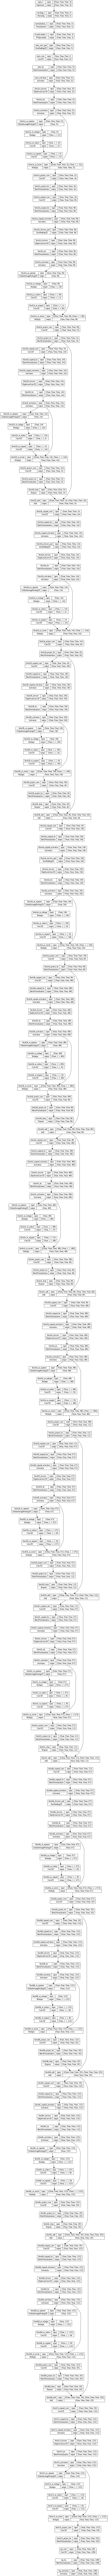

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(feature_model,
           show_shapes = True,
           show_dtype=False,
           show_layer_names = True,
           rankdir = 'TB',
           expand_nested = False,
           dpi = 70)

plot_model(base_model,
           show_shapes = True,
           show_dtype=False,
           show_layer_names = True,
           rankdir = 'TB',
           expand_nested = False,
           dpi = 70)

In [ ]:
initial_epochs = 4
history = feature_model.fit(
    train_data,
    epochs=initial_epochs,
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    validation_steps=len(test_data),
    callbacks=[early_stopping, model_checkpoint, reduce_lr, create_tensorboard_callback('plant_disease_model', 'EfficientNetB010')]
)

Saving TensorBoard log files to: plant_disease_model/EfficientNetB010/20241104-050404
Epoch 1/4
239/239 [==============================] - 1219s 5s/step - loss: 0.0807 - accuracy: 0.9740 - val_loss: 0.0187 - val_accuracy: 0.9948 - lr: 0.0010
Epoch 2/4
239/239 [==============================] - 912s 4s/step - loss: 0.0203 - accuracy: 0.9933 - val_loss: 0.0046 - val_accuracy: 0.9979 - lr: 0.0010
Epoch 3/4
239/239 [==============================] - 879s 4s/step - loss: 0.0126 - accuracy: 0.9955 - val_loss: 0.0564 - val_accuracy: 0.9855 - lr: 0.0010
Epoch 4/4
239/239 [==============================] - ETA: 0s - loss: 0.0279 - accuracy: 0.9916
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
239/239 [==============================] - 966s 4s/step - loss: 0.0279 - accuracy: 0.9916 - val_loss: 0.0132 - val_accuracy: 0.9954 - lr: 0.0010


In [ ]:
feature_model.load_weights(checkpoint_path)

In [ ]:

# Model Evaluation
print("Evaluating model...")
val_loss, val_accuracy = feature_model.evaluate(test_data, steps=len(test_data))
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

Evaluating model...
61/61 [==============================] - 185s 3s/step - loss: 0.0046 - accuracy: 0.9979
Validation Loss: 0.0046
Validation Accuracy: 97.05%


In [ ]:
feature_model.save('best_plant_model.h5')

In [ ]:
def load_prep(img_path):
  img = tf.io.read_file(img_path)

  img = tf.image.decode_image(img)

  img = tf.image.resize(img,size=(224,224))

  return img


Text(0.5, 0.98, '(224, 224, 3)')

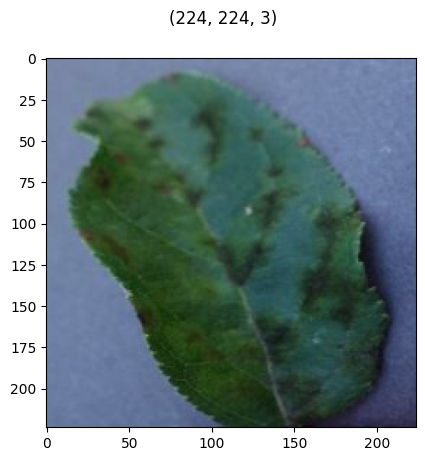

In [ ]:
image = load_prep('/content/drive/MyDrive/Apple leaf disease dataset/test/AppleScab2.JPG')
plt.imshow(image/255.)
plt.suptitle(image.shape)

In [ ]:
pred = feature_model.predict(tf.expand_dims(image,axis=0))
pred

predicted_value = class_names[pred.argmax()]
predicted_value

1/1 [==============================] - 2s 2s/step


'scab'

In [ ]:
def random_image_predict(model,test_dir=test_dir,class_names=class_names,rand_class=True,cls_name=None):
  if rand_class==True:
    #The stop value for randint is now the length of class_names -1, which prevents an index out of bounds error.
    ran_cls = random.randint(0,len(class_names)-1)
    cls = class_names[ran_cls]
    ran_path = test_dir +'/'+ cls+ '/'+ random.choice(os.listdir(test_dir+'/'+cls))
  else:
    cls = class_names[cls_name]
    ran_path = test_dir +'/'+ cls + '/'+ random.choice(os.listdir(test_dir+'/'+cls))

  prep_img = load_prep(ran_path)

  pred = model.predict(tf.expand_dims(prep_img,axis=0))
  pred_cls = class_names[pred[0].argmax()]
  pred_percent = pred[0][pred[0].argmax()]*100
  plt.imshow(prep_img/255.)
  if pred_cls == cls:
    c = 'g'
  else:
    c = 'r'
  plt.title(f'actual:{cls},\npred:{pred_cls},\nprob:{pred_percent:.2f}%',color = c ,fontdict={'fontsize':10})
  plt.axis(False)

1/1 [==============================] - 0s 106ms/step


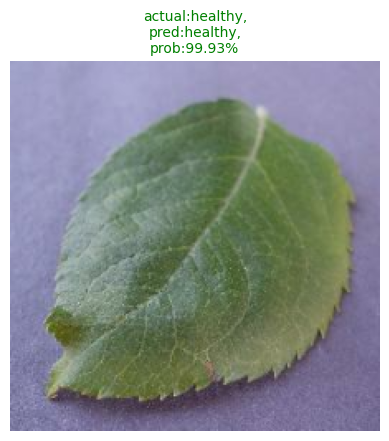

In [ ]:
random_image_predict(feature_model)

1/1 [==============================] - 0s 87ms/step


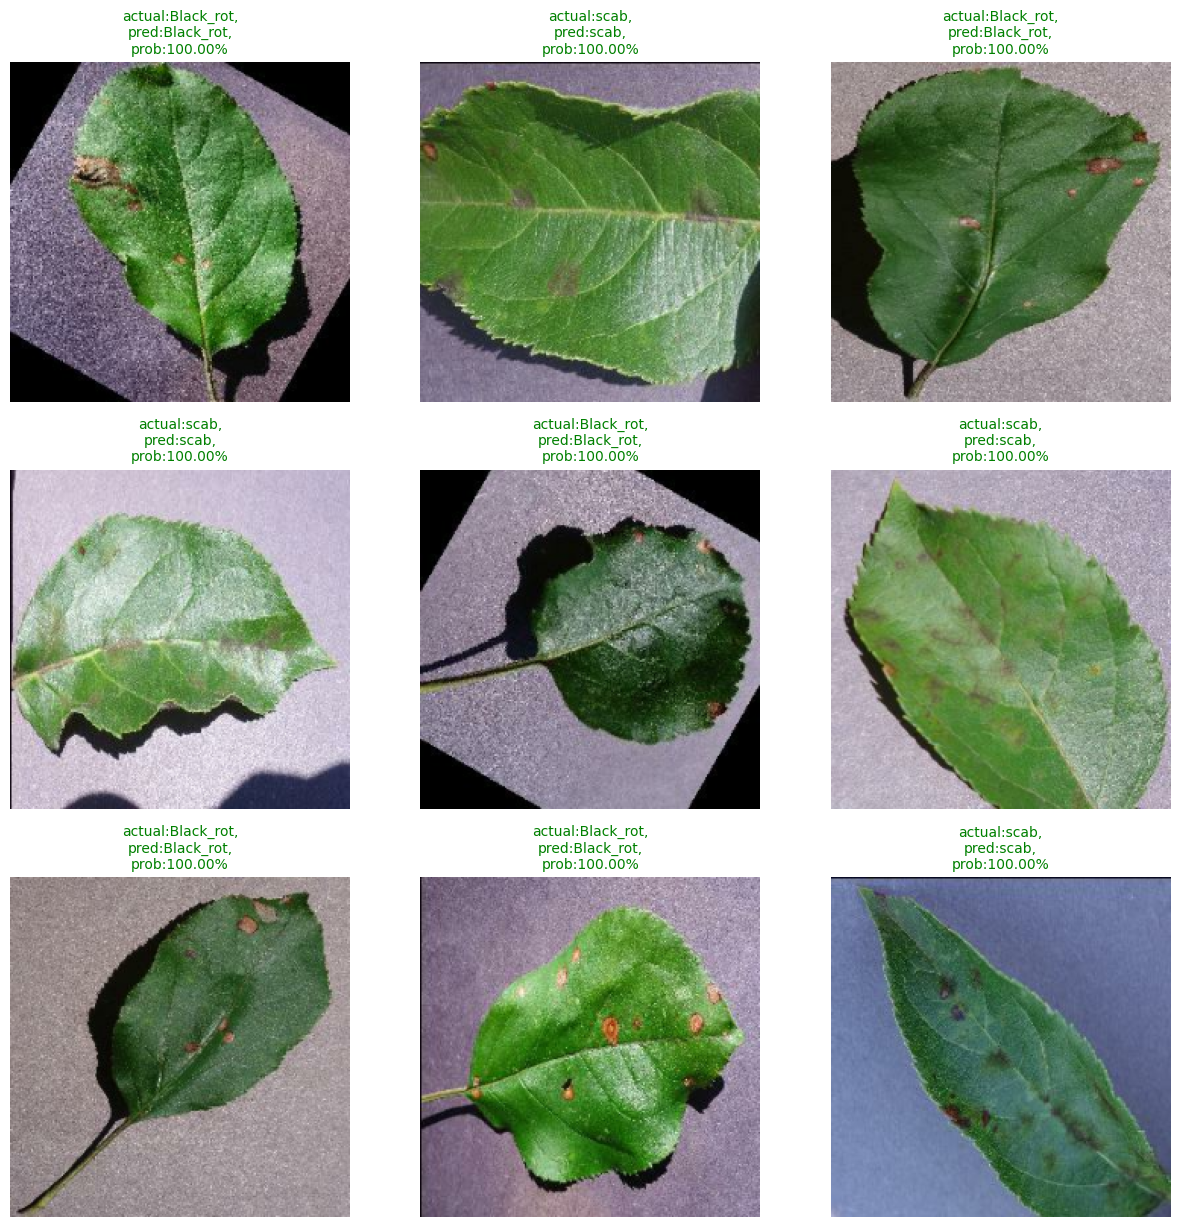

In [ ]:
plt.figure(figsize=(15,15))
for i in range(9):
  plt.subplot(3,3,i+1)
  random_image_predict(feature_model,test_dir)

In [ ]:
data_dir='/content/drive/MyDrive/Apple leaf disease dataset/test'
plt.figure(figsize=(15,10))
for i in range(9):
  plt.subplot(3,3,i+1)
  rn = random.choice(os.listdir(data_dir))
  image_path=os.path.join(data_dir,rn)
  img = load_prep(image_path)
  pred = feature_model.predict(tf.expand_dims(img,axis=0))
  pred_name = class_names[pred.argmax()]
  plt.imshow(img/255.)
  plt.title(f'true:{rn} \npred_class:{pred_name}')
  plt.axis(False)

1/1 [==============================] - 0s 89ms/step


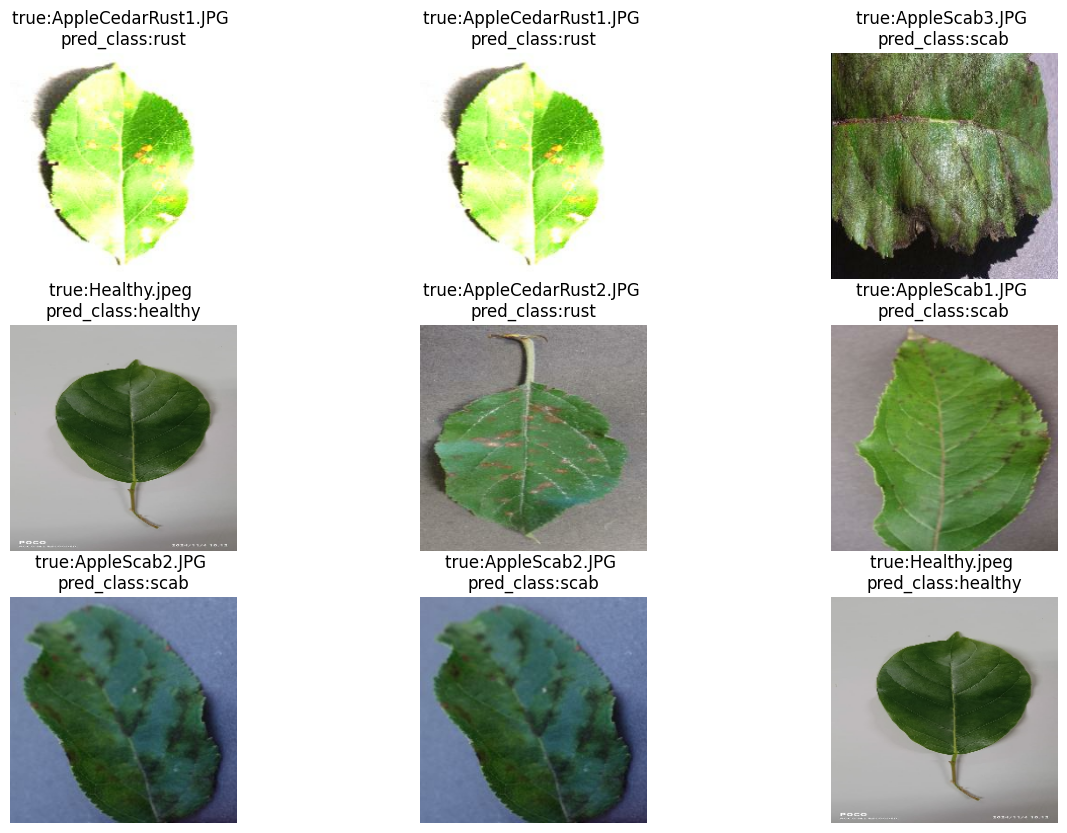

In [ ]:
import os
import random

def random_image_predict(model,test_dir=test_dir,class_names=class_names,rand_class=True,cls_name=None):
    if rand_class==True:
        #The stop value for randint is now the length of class_names -1, which prevents an index out of bounds error.
        ran_cls = random.randint(0,len(class_names)-1)
        cls = class_names[ran_cls]
        ran_path = test_dir +'/'+ cls+ '/'+ random.choice(os.listdir(test_dir+'/'+cls))
    else:
        cls = class_names[cls_name]
        ran_path = test_dir +'/'+ cls + '/'+ random.choice(os.listdir(test_dir+'/'+cls))

    prep_img = load_prep(ran_path)

    pred = model.predict(tf.expand_dims(prep_img,axis=0))
    pred_cls = class_names[pred[0].argmax()]
    pred_percent = pred[0][pred[0].argmax()]*100
    plt.imshow(prep_img/255.)
    if pred_cls == cls:
        c = 'g'
    else:
        c = 'r'
    plt.title(f'actual:{cls},\npred:{pred_cls},\nprob:{pred_percent:.2f}%',color = c ,fontdict={'fontsize':10})
    plt.axis(False)

import os
import random
import tensorflow as tf
import matplotlib.pyplot as plt
data_dir='/content/drive/MyDrive/Apple leaf disease dataset/test'
plt.figure(figsize=(15,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    # Get a list of all files and directories in data_dir
    items = os.listdir(data_dir)
    # Filter out directories and keep only files
    files = [item for item in items if os.path.isfile(os.path.join(data_dir, item))]
    # Choose a random file from the filtered list
    rn = random.choice(files)

    image_path=os.path.join(data_dir,rn)
    img = load_prep(image_path)
    pred = feature_model.predict(tf.expand_dims(img,axis=0))
    pred_name = class_names[pred.argmax()]
    plt.imshow(img/255.)
    plt.title(f'true:{rn} \npred_class:{pred_name}')
    plt.axis(False)

In [ ]:
def predict_img(img_path,model=feature_model,):
  img = load_prep(img_path)

  pred = model.predict(tf.expand_dims(img,axis=0))

  pred_name = class_names[pred.argmax()]

  plt.imshow(img/255.)
  plt.title(f'predicted_class : {pred_name}')
  plt.axis(False)

1/1 [==============================] - 0s 91ms/step


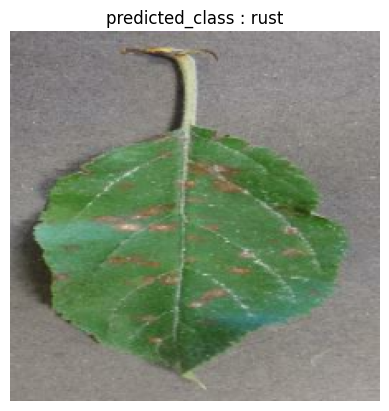

In [ ]:
predict_img('/content/drive/MyDrive/Apple leaf disease dataset/test/AppleCedarRust2.JPG')

1/1 [==============================] - 0s 92ms/step


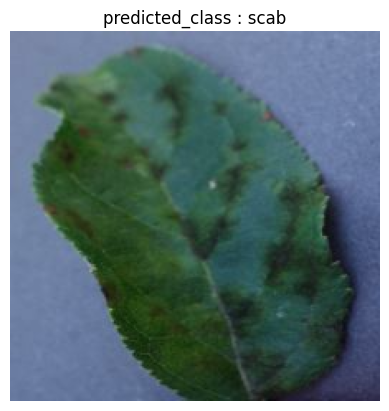

In [ ]:
predict_img('/content/drive/MyDrive/Apple leaf disease dataset/test/AppleScab2.JPG')

1/1 [==============================] - 0s 88ms/step


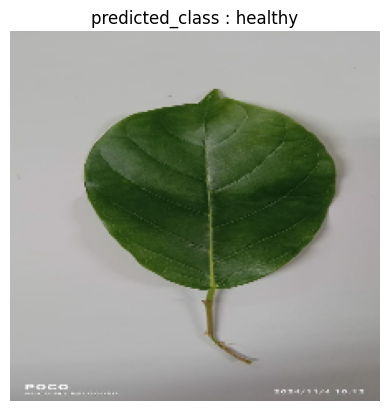

In [ ]:
predict_img('/content/drive/MyDrive/Apple leaf disease dataset/test/Healthy.jpeg')

1/1 [==============================] - 0s 88ms/step


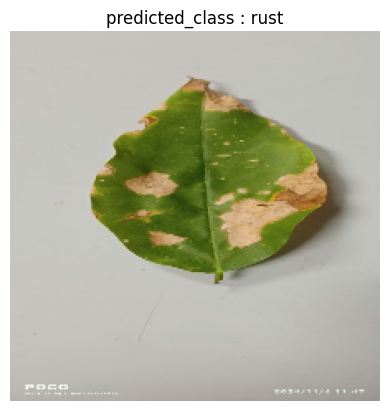

In [ ]:
predict_img('/content/drive/MyDrive/Apple leaf disease dataset/test/rust.jpeg')

1/1 [==============================] - 0s 90ms/step


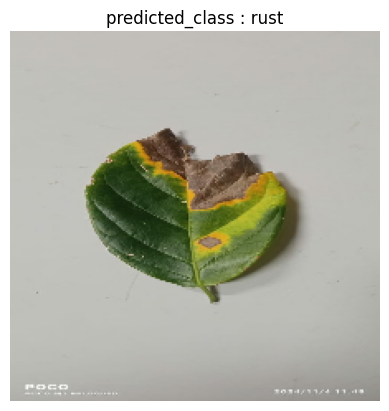

In [ ]:
predict_img('/content/drive/MyDrive/Apple leaf disease dataset/test/rust1.jpeg')